In [3]:
import sys
sys.path.insert(0, '../util')
sys.path.insert(1, '../experiments')

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [4]:
from pathlib import Path
import re
from convert_annotations import read_webanno, webanno_to_iob_df, join_and_resolve, EMPTY_REGEX, VALUE_REGEX
import pandas as pd
import transformers
from transformers import AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline, DataCollatorForTokenClassification, EarlyStoppingCallback, trainer_utils
from huggingface_utils import load_custom_dataset, LabelAligner, compute_metrics, eval_on_test_set
from run_experiment import get_train_args

## Error Analysis

In [5]:
import hydra
from hydra import compose, initialize

In [6]:
def load_pipeline_and_data(setting):
    cfg_file = f'{setting}.yaml'
    model_checkpoint = f'../data/models/{setting}/'

    hydra.core.global_hydra.GlobalHydra.instance().clear()
    initialize(config_path=Path('..') / 'experiments')
    config = compose(config_name=cfg_file, overrides=['cuda=0', 'link=false'])
    
    tokenizer = AutoTokenizer.from_pretrained(config['base_model_checkpoint'])
    
    dataset, tags = load_custom_dataset(train=config['train_dataset'], dev=config['dev_dataset'], test=config['test_dataset'], tag_strings=config['task'])
    
    assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)
    
    label_aligner = LabelAligner(tokenizer)
    dataset = dataset.map(lambda e: label_aligner.tokenize_and_align_labels(e, config['label_all_tokens']), batched=True)
    
    training_args = get_train_args(cp_path='../ner_results', run_name='error_analysis', report_to=[], **config, resume_from_checkpoint=model_checkpoint)
    
    model = AutoModelForTokenClassification.from_pretrained(
        model_checkpoint
    )

    data_collator = DataCollatorForTokenClassification(tokenizer)
    tr = Trainer(
        args=training_args,
        model=model,
        train_dataset=dataset["train"],
        eval_dataset=dataset["dev"],
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics(tags, True),
    )
    
    return tr, model, dataset["test"], tokenizer

In [9]:
tr_short, model_short, test_ds_short, tokenizer = load_pipeline_and_data('02_ggponc_fine_short')
tr_long, model_long, test_ds_long, _ = load_pipeline_and_data('04_ggponc_fine_long')

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

INFO:run_experiment:error_analysis
Using amp fp16 backend
loading configuration file https://huggingface.co/deepset/gbert-base/resolve/main/config.json from cache at /dhc/home/florian.borchert/.cache/huggingface/transformers/0f9d6c73cd85ab98cecc6866492c84f23e72bbaf2240a24da0e5d5e3b8810707.080f0bd0794ab07ca509487675f6cb88cfbdc04fc142b21be92212223e82cb14
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.2",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31102
}

loading file https://huggingface.co/deepset/gbert-base/reso

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

INFO:run_experiment:error_analysis
PyTorch: setting up devices
loading configuration file ../data/models/04_ggponc_fine_long/config.json
Model config BertConfig {
  "_name_or_path": "deepset/gbert-base",
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-Other_Finding",
    "2": "I-Other_Finding",
    "3": "B-Diagnosis_or_Pathology",
    "4": "I-Diagnosis_or_Pathology",
    "5": "B-Therapeutic",
    "6": "I-Therapeutic",
    "7": "B-Diagnostic",
    "8": "I-Diagnostic",
    "9": "B-Nutrient_or_Body_Substance",
    "10": "I-Nutrient_or_Body_Substance",
    "11": "B-External_Substance",
    "12": "I-External_Substance",
    "13": "B-Clinical_Drug",
    "14": "I-Clinical_Drug"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LA

In [10]:
from transformers.pipelines.token_classification import AggregationStrategy
pipe_short = pipeline("ner", model_short, tokenizer=tokenizer, device=0, aggregation_strategy=AggregationStrategy.FIRST)
pipe_long = pipeline("ner", model_long, tokenizer=tokenizer, device=0, aggregation_strategy=AggregationStrategy.FIRST)

In [11]:
wiki_sentence = """"Cetuximab ist ein monoklonaler Antikörper, der gegen den epidermalen Wachstumsfaktorrezeptor (EGFR) gerichtet ist und 
dient zur Therapie des fortgeschrittenen kolorektalen Karzinoms zusammen mit Irinotecan oder in Kombination mit FOLFOX bzw. 
allein nach Versagen einer Behandlung mit Oxaliplatin und Irinotecan."""

In [12]:
pipe_short(wiki_sentence)

[{'entity_group': 'Clinical_Drug',
  'score': 0.96303827,
  'word': 'Cetuximab',
  'start': 1,
  'end': 10},
 {'entity_group': 'Clinical_Drug',
  'score': 0.9632393,
  'word': 'Antikörper',
  'start': 32,
  'end': 42},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.9633988,
  'word': 'Wachstumsfaktorrezeptor',
  'start': 70,
  'end': 93},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.964254,
  'word': 'EGFR',
  'start': 95,
  'end': 99},
 {'entity_group': 'Therapeutic',
  'score': 0.9626832,
  'word': 'Therapie',
  'start': 130,
  'end': 138},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.9633034,
  'word': 'Karzinoms',
  'start': 174,
  'end': 183},
 {'entity_group': 'Clinical_Drug',
  'score': 0.96274924,
  'word': 'Irinotecan',
  'start': 197,
  'end': 207},
 {'entity_group': 'Therapeutic',
  'score': 0.96200514,
  'word': 'FOLFOX',
  'start': 232,
  'end': 238},
 {'entity_group': 'Other_Finding',
  'score': 0.66180867,
  'word': 'Versagen',
 

In [13]:
pipe_long(wiki_sentence)

[{'entity_group': 'Clinical_Drug',
  'score': 0.9999979,
  'word': 'Cetuximab',
  'start': 1,
  'end': 10},
 {'entity_group': 'Clinical_Drug',
  'score': 0.99999464,
  'word': 'monoklonaler Antikörper',
  'start': 19,
  'end': 42},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.9999898,
  'word': 'epidermalen Wachstumsfaktorrezeptor',
  'start': 58,
  'end': 93},
 {'entity_group': 'Nutrient_or_Body_Substance',
  'score': 0.99998355,
  'word': 'EGFR',
  'start': 95,
  'end': 99},
 {'entity_group': 'Therapeutic',
  'score': 0.9999932,
  'word': 'Therapie des fortgeschrittenen kolorektalen Karzinoms',
  'start': 130,
  'end': 183},
 {'entity_group': 'Clinical_Drug',
  'score': 0.99996597,
  'word': 'Irinotecan',
  'start': 197,
  'end': 207},
 {'entity_group': 'Therapeutic',
  'score': 0.99939084,
  'word': 'FOLFOX',
  'start': 232,
  'end': 238},
 {'entity_group': 'Other_Finding',
  'score': 0.9010091,
  'word': 'Versagen einer Behandlung mit Oxaliplatin und Irinotecan',
  

In [14]:
test_set_metrics_short = eval_on_test_set(test_ds_short, tr_short, tokenizer, "test_short_full")
test_set_metrics_long = eval_on_test_set(test_ds_long, tr_long, tokenizer, "test_long_full")

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: offset_mapping, tags, _tags, tokens, fname, special_tokens_mask, sentence_id.
***** Running Prediction *****
  Num examples = 4826
  Batch size = 32


4826it [00:02, 2186.19it/s]
The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: offset_mapping, tags, _tags, tokens, fname, special_tokens_mask, sentence_id.
***** Running Prediction *****
  Num examples = 4826
  Batch size = 32


4826it [00:02, 2134.92it/s]


# Read coordination ellipses

Annotators were asked to annotate ellipses and their corresponding resolution using the `prefix` and `suffix` items as well as `fragment` relations for morpheme coordination (i.e., omission of subwords, in German commonly indicated by a Auslassungsstrich "-")

### Read the data from WebAnno TSV files

In [27]:
%%time
tsv_folder = '../data/annotations/webanno'

webanno_df = read_webanno(Path(tsv_folder).glob('*.tsv'))

CPU times: user 25.7 s, sys: 781 ms, total: 26.4 s
Wall time: 28.9 s


In [28]:
%%time
iob_df = webanno_to_iob_df(webanno_df, 'detail', True, debug=False, collect_errors=False, skip_errors=True, all_columns=True)
iob_df['id'] = iob_df.entity_id.where(~iob_df.entity_id.isna(), iob_df.spec_id)

  0%|          | 0/45031 [00:00<?, ?it/s]/dhc/home/florian.borchert/workspace/ggponc_annotation/notebooks/../util/convert_annotations.py:70: PerformanceWarning: indexing past lexsort depth may impact performance.
  d = webanno_df.loc[(file, sentence_id)]
 19%|█▊        | 8368/45031 [02:08<09:58, 61.27it/s]ERROR:convert_annotations:05_zervixkarzinom_0132.tsv, 7, ('Stuck expanding sections',)
ERROR:convert_annotations:05_zervixkarzinom_0132.tsv, 9, ('Stuck expanding sections',)
 48%|████▊     | 21440/45031 [05:13<07:00, 56.09it/s]ERROR:convert_annotations:14_larynxkarzinom_0008.tsv, 12, ('Stuck expanding sections',)
ERROR:convert_annotations:14_larynxkarzinom_0008.tsv, 13, ('Stuck expanding sections',)
 68%|██████▊   | 30462/45031 [07:27<03:19, 72.87it/s]ERROR:convert_annotations:20_harnblasenkarzinom_0150.tsv, 7, ('Stuck expanding sections',)
ERROR:convert_annotations:20_harnblasenkarzinom_0150.tsv, 8, ('Stuck expanding sections',)
 91%|█████████▏| 41099/45031 [09:57<00:42, 92.27it/s] E

CPU times: user 11min 22s, sys: 4.77 s, total: 11min 27s
Wall time: 11min 22s


In [31]:
# Anything containing a prefix, suffix or fragment is potentially an elliptical construct
ellipses = iob_df[~iob_df.prefix.str.match(EMPTY_REGEX) | ~iob_df.suffix.str.match(EMPTY_REGEX) | ~iob_df.fragment.str.match(EMPTY_REGEX) ].copy()

### Resolve ellipses and connect fragment parts

In [32]:
%%time
results = []
for _, r in ellipses.id.reset_index().drop_duplicates().iterrows():
    has_fragment = False
    idx = r.file, r.sentence_id
    _id = r.id
    sentence = ellipses.loc[idx]
    span = sentence[sentence.id == _id]
    full_sentence = iob_df.loc[idx]
    full_span = full_sentence[full_sentence.id == _id]
    for fragment in span.fragment: # Expand span to fragments
        if fragment and not re.match(EMPTY_REGEX, fragment):
            has_fragment = True
            fragment = re.split('[|;]', fragment)[0]
            m = re.match(VALUE_REGEX, fragment)
            if not m:
                print(span.fragment)
            fragment_index = int(m.group(1).split('-')[1])
            fragment_start = min(fragment_index, full_span.token_id.min())
            fragment_end = max(fragment_index, full_span.token_id.max())
            full_span = full_sentence[(full_sentence.token_id >= fragment_start) & (full_sentence.token_id <= fragment_end)]
            expanded_context = full_sentence[full_sentence.id.isin(full_span.id.dropna().unique())].token_id
            fragment_start = min(fragment_start, expanded_context.min())
            fragment_end = max(fragment_end, expanded_context.max())
            full_span = full_sentence[(full_sentence.token_id >= fragment_start) & (full_sentence.token_id <= fragment_end)]
    fragment, resolution, missing_prefix, missing_suffix = join_and_resolve(full_span)
    results.append({
        'file' : idx[0],
        'sentence_id' : idx[1],
        'full_sentence' : list(full_sentence.token),
        'span_index_start': full_span.token_id.min() - 1,
        'span_index_end' : full_span.token_id.max() - 1,
        'full_span' : fragment,
        'resolution' : resolution,
        'fragment' : has_fragment,
        'missing_prefix' : missing_prefix,
        'missing_suffix' : missing_suffix,
    })
results = pd.DataFrame(results)

<timed exec>:8: PerformanceWarning: indexing past lexsort depth may impact performance.


CPU times: user 15.6 s, sys: 51.5 ms, total: 15.6 s
Wall time: 15.6 s


### Statistics


In [79]:
ellipses_sentence_count = len(results[['file', 'sentence_id']].drop_duplicates())
sentence_count = len(iob_df.index.drop_duplicates())
ellipses_sentence_count, sentence_count, ellipses_sentence_count / sentence_count

(2619, 44972, 0.058236235880103175)

In [71]:
print('Ellipses', len(results))
print('Forward ellipses', len(results[results.missing_prefix & ~results.missing_suffix]), len(results[results.fragment & results.missing_prefix & ~results.missing_suffix]))
print('Backward ellipses', len(results[~results.missing_prefix & results.missing_suffix]), len(results[results.fragment & ~results.missing_prefix & results.missing_suffix]))
print('Complex ellipses', len(results[results.missing_prefix & results.missing_suffix]), len(results[results.fragment & results.missing_prefix & results.missing_suffix]))

Ellipses 2929
Forward ellipses 1066 447
Backward ellipses 1663 1534
Complex ellipses 181 131


### Browsing random examples and their resolution

In [33]:
import random

def show_random(df):
    i = random.randint(0, len(df))
    item = df.iloc[i]    
    assert len(item.full_span) == len(item.resolution)
    spans = []
    solutions = []
    marker = []
    for span, res in zip(item.full_span, item.resolution):
        if span == res:
            marker.append(' ' * len(span))
        else:
            marker.append('^' * len(res))
        start_index = res.find(span)
        spans.append(span.rjust(start_index + len(span)).ljust(len(res) - start_index))
        solutions.append(res)
    print(' '.join(spans))
    print(' '.join(solutions))
    print(' '.join(marker))
    print(item.file, item.sentence_id, 'fragment:', item.fragment)
    print('...........')
    print('')

Examples with fragment attribute (typically elliptical compounds)

In [35]:
for _ in range(0, 10):
    show_random(results[results.fragment])

Diagnose         - und Therapieoptionen
Diagnoseoptionen - und Therapieoptionen
^^^^^^^^^^^^^^^^                       
09_mammakarzinom_0000.tsv 19 fragment: True
...........

Darmkrebs-Vorsorge / -           Früherkennung
Darmkrebs-Vorsorge / - Darmkrebs-Früherkennung
                       ^^^^^^^^^^^^^^^^^^^^^^^
02_kolorektales-karzinom_0031.tsv 2 fragment: True
...........

hereditary breast                ovarian cancer syndrome
hereditary breastcancer syndrome ovarian cancer syndrome
           ^^^^^^^^^^^^^^^^^^^^^                        
16_maligne-ovarialtumoren_0030.tsv 3 fragment: True
...........

adjuvanten Chemo         - oder Radiotherapie
adjuvanten Chemotherapie - oder Radiotherapie
           ^^^^^^^^^^^^^                     
13_oesophaguskarzinom_0099.tsv 9 fragment: True
...........

1                  - , 3                  - und 5 - Jahres-Überleben
1-Jahres-Überleben - , 3-Jahres-Überleben - und 5 - Jahres-Überleben
^^^^^^^^^^^^^^^^^^     ^^^^^^^^^^^^^^^^^^    

Examples without fragment attribute (often omitted prepositions)

In [37]:
for _ in range(0, 10):
    show_random(results[~results.fragment])

hoher Konsum von rotem Fleisch ( Rind , Kalb , Schwein und Lamm ) und     verarbeitetem Fleisch
hoher Konsum von rotem Fleisch ( Rind , Kalb , Schwein und Lamm ) und von verarbeitetem Fleisch
                                                                      ^^^^^^^^^^^^^^^^^        
02_kolorektales-karzinom_0012.tsv 1 fragment: False
...........

erhöhtes Risiko für ein lokales oder lokoregionäres Rezidiv ( 3 - 24% ) , Fernmetastasen ( 25% ) oder     einen metachronen Zweittumor
erhöhtes Risiko für ein lokales oder lokoregionäres Rezidiv ( 3 - 24% ) , Fernmetastasen ( 25% ) oder für einen metachronen Zweittumor
                                                                                                      ^^^^^^^^^                       
02_kolorektales-karzinom_0496.tsv 2 fragment: False
...........

alkoholisch           oder HBV bedingter Leberzirrhose
alkoholisch bedingter oder HBV bedingter Leberzirrhose
^^^^^^^^^^^^^^^^^^^^^                                 
11_hepatozel

### Evaluation of NER models on these instances

In [38]:
idx = set(results.set_index(['file', 'sentence_id']).index.unique().values)
idx_frag = set(results[results.fragment].set_index(['file', 'sentence_id']).index.unique().values)

In [39]:
test_ds_short_ellipsis = test_ds_short.filter(lambda item: (item['fname'], item['sentence_id']) in idx)
test_ds_short_fragment = test_ds_short.filter(lambda item: (item['fname'], item['sentence_id']) in idx_frag)
test_ds_long_ellipsis = test_ds_long.filter(lambda item: (item['fname'], item['sentence_id']) in idx)
test_ds_long_fragment = test_ds_long.filter(lambda item: (item['fname'], item['sentence_id']) in idx_frag)

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

In [40]:
test_set_metrics_short_ellipses = eval_on_test_set(test_ds_short_ellipsis, tr_short, tokenizer, "test_short_ellipsis")
test_set_metrics_short_fragment = eval_on_test_set(test_ds_short_fragment, tr_short, tokenizer, "test_short_fragment")
test_set_metrics_long_ellipses = eval_on_test_set(test_ds_long_ellipsis, tr_long, tokenizer, "test_long_ellipsis")
test_set_metrics_long_fragment = eval_on_test_set(test_ds_long_fragment, tr_long, tokenizer, "test_long_fragment")

The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: offset_mapping, tags, _tags, tokens, fname, special_tokens_mask, sentence_id.
***** Running Prediction *****
  Num examples = 282
  Batch size = 32
282it [00:00, 1625.78it/s]
The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: offset_mapping, tags, _tags, tokens, fname, special_tokens_mask, sentence_id.
***** Running Prediction *****
  Num examples = 193
  Batch size = 32
193it [00:00, 1645.90it/s]
The following columns in the test set  don't have a corresponding argument in `BertForTokenClassification.forward` and have been ignored: offset_mapping, tags, _tags, tokens, fname, special_tokens_mask, sentence_id.
***** Running Prediction *****
  Num examples = 282
  Batch size = 32
282it [00:00, 1579.54it/s]
The following columns in the test set  don't have a correspon

In [41]:
error_cols = ['false_negative', 'false_positive', 'labeling_error', 'boundary_error', 'label_boundary_error']

In [42]:
def get_dataframe(metrics):
    count = 0
    for k, v in metrics.items():
        if '_number' in k:
            count += v
    data = {}
    key = None
    for k_long, v in metrics.items():
        subset, k = tuple(k_long.split('/'))
        assert not key or key == subset
        key = subset
        if k in error_cols + ['true_positive']:
            data[f"{k}_abs"] = v
            data[f"{k}"] = v / count
        if k == 'overall_f1':
            data[k] = v
    data['subset'] = subset
    return pd.DataFrame([data]).set_index('subset')

In [43]:
stats = pd.concat([
    get_dataframe(test_set_metrics_short),
    get_dataframe(test_set_metrics_short_ellipses),
    get_dataframe(test_set_metrics_short_fragment),
    get_dataframe(test_set_metrics_long),
    get_dataframe(test_set_metrics_long_ellipses),
    get_dataframe(test_set_metrics_long_fragment),
])

In [44]:
import matplotlib
from matplotlib import pyplot as plt
from matplotlib import cm

In [45]:
matplotlib.rcParams.update({'font.size': 16})

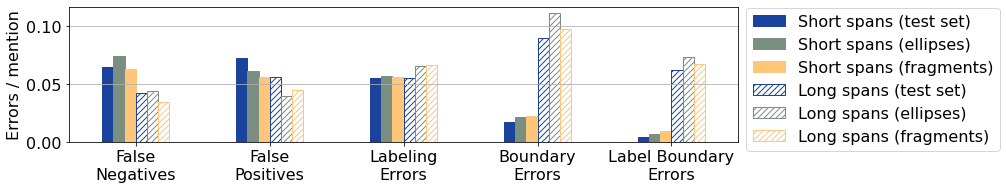

In [46]:
ax = plt.figure(figsize=(12,2.5)).add_subplot(111)

stats[error_cols].T.rename(
    {
        'false_negative' : 'False\nNegatives',
        'false_positive' : 'False\nPositives',
        'labeling_error' : 'Labeling\nErrors',
        'boundary_error' : 'Boundary\nErrors',
        'label_boundary_error' : 'Label Boundary\nErrors',
    }).rename({
        'test_short_full' : 'Short spans (test set)',
        'test_short_ellipsis' : 'Short spans (ellipses)',
        'test_short_fragment' : 'Short spans (fragments)',
        'test_long_full' : 'Long spans (test set)',
        'test_long_ellipsis' : 'Long spans (ellipses)',
        'test_long_fragment' : 'Long spans (fragments)'
    }, axis=1
    ).plot.bar(rot=0, ax=ax
)

ax.grid(axis='y')

c1, c2, c3 = '#19439c', '#7a8e82', '#ffc67a'

bars = ax.patches
hatches = [None] * 15 + ['////'] * 15
colors = ([c1] * 5 + [c2] * 5 + [c3] * 5) * 3

for bar, hatch, color in zip(bars, hatches, colors):
    if not hatch:
        bar.set_color(color)
    else:
        bar.set_color('white')
    bar.set_edgecolor(color)
    bar.set_hatch(hatch)

    
ax.set_ylabel('Errors / mention')
    
plt.legend(bbox_to_anchor=(1.0, 1.05))

plt.savefig('error_analysis.png', dpi=600, bbox_inches="tight")

plt.show()

### Manual inspection

In [83]:
pipe_long('platinresistentem und/oder -refraktärem Ovarialkarzinomrezidiv')

[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.99999344,
  'word': 'platinresistentem und / oder - refraktärem Ovarialkarzinomrezidiv',
  'start': 0,
  'end': 62}]

In [86]:
pipe_long('Krebs-Vorsorge / -Früherkennung')

[{'entity_group': 'Therapeutic',
  'score': 0.9937671,
  'word': 'Krebs',
  'start': 0,
  'end': 5},
 {'entity_group': 'Therapeutic',
  'score': 0.9870125,
  'word': 'Vorsorge',
  'start': 6,
  'end': 14},
 {'entity_group': 'Diagnostic',
  'score': 0.9999946,
  'word': 'Früherkennung',
  'start': 18,
  'end': 31}]

In [89]:
pipe_long('HPV31, 33, 45 und 51')

[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.99999386,
  'word': 'HPV31, 33, 45 und 51',
  'start': 0,
  'end': 20}]

In [90]:
pipe_long('Chemo- und Strahlentherapie')

[{'entity_group': 'Therapeutic',
  'score': 0.9999935,
  'word': 'Chemo',
  'start': 0,
  'end': 5},
 {'entity_group': 'Therapeutic',
  'score': 0.99998856,
  'word': 'Strahlentherapie',
  'start': 11,
  'end': 27}]

In [91]:
pipe_long('BRAF- und MEK-Inhibitor')

[{'entity_group': 'Clinical_Drug',
  'score': 0.99998844,
  'word': 'BRAF',
  'start': 0,
  'end': 4},
 {'entity_group': 'Clinical_Drug',
  'score': 0.999976,
  'word': 'MEK - Inhibitor',
  'start': 10,
  'end': 23}]

In [92]:
pipe_long('zielgerichtete und Immuntherapien')

[{'entity_group': 'Therapeutic',
  'score': 0.9999915,
  'word': 'zielgerichtete',
  'start': 0,
  'end': 14},
 {'entity_group': 'Therapeutic',
  'score': 0.99735475,
  'word': 'Immuntherapien',
  'start': 19,
  'end': 33}]

In [93]:
pipe_long('neo- / adjuvante Therapie')

[{'entity_group': 'Therapeutic',
  'score': 0.9999955,
  'word': 'neo - / adjuvante Therapie',
  'start': 0,
  'end': 25}]

In [94]:
pipe_long('HPV-16- und/oder -18-Positivität')

/dhc/home/florian.borchert/conda3/envs/ggponc/lib/python3.9/site-packages/transformers/pipelines/base.py:908: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.9999859,
  'word': 'HPV - 16',
  'start': 0,
  'end': 6},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.8065756,
  'word': '-',
  'start': 17,
  'end': 18},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.8767609,
  'word': '18 - Positivität',
  'start': 18,
  'end': 32}]

In [96]:
pipe_long('BRCA1/2-Mutation')

[{'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.99999005,
  'word': 'BRCA1',
  'start': 0,
  'end': 5},
 {'entity_group': 'Diagnosis_or_Pathology',
  'score': 0.9998572,
  'word': '2 - Mutation',
  'start': 6,
  'end': 16}]

In [99]:
pipe_long('5-Alpha-Reduktase-Typ-I- und II-Hemmer')

[{'entity_group': 'Clinical_Drug',
  'score': 0.99999684,
  'word': '5 - Alpha - Reduktase - Typ - I - und II - Hemmer',
  'start': 0,
  'end': 38}]

In [101]:
pipe_long('Zweitlinien- oder Drittliniensystem- bzw. -chemotherapie')

/dhc/home/florian.borchert/conda3/envs/ggponc/lib/python3.9/site-packages/transformers/pipelines/base.py:908: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


[{'entity_group': 'Therapeutic',
  'score': 0.9999825,
  'word': 'Zweitlinien',
  'start': 0,
  'end': 11},
 {'entity_group': 'Therapeutic',
  'score': 0.99999595,
  'word': 'Drittliniensystem',
  'start': 18,
  'end': 35},
 {'entity_group': 'Therapeutic',
  'score': 0.9999942,
  'word': 'chemotherapie',
  'start': 43,
  'end': 56}]